0    01/01/1956
1    01/02/1956
2    01/03/1956
3    01/04/1956
4    01/05/1956
5    01/06/1956
6    01/07/1956
7    01/08/1956
8    01/09/1956
9    01/10/1956
Name: Fecha, dtype: object
0    7.134094
1    7.162397
2    7.229114
3    7.204893
4    7.336286
Name: TOTAL, dtype: float64


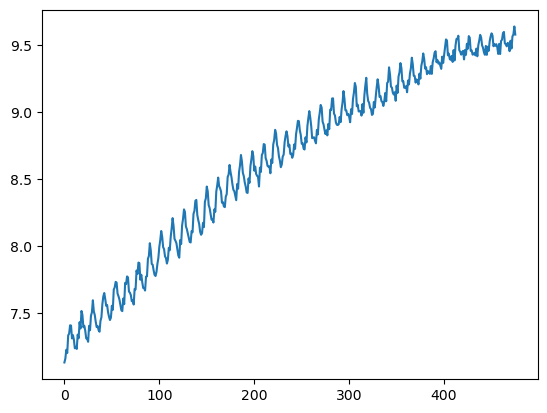

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

datos = pd.read_csv('AusElectDemand.csv', sep=";",decimal=",")

# x is the 1st column of the dataset representing the time
x = datos.iloc[:,0]
print(x.head(10))

# y is the 2nd column of the dataset representing the earnings
y = datos.iloc[:,1]

# select last 180 observations (15 years)
# y = y[-180:]

# apply log transformation
y = np.log(y)

print(y.head())
plt.plot(y)
plt.show()

In [2]:
import statsmodels as sm
import pmdarima
from pmdarima.arima import ndiffs, nsdiffs

# Ho: the process is not stationary. We need, at least, a unit root
# H1: the process is stationary. We have to check different models (lags)

adf_test = sm.tsa.stattools.adfuller(y,maxlag=10) 
# print("adf_test", adf_test) # first output "The test statistic", second output "p-value"
print("ADF test for the original series")
print("Statistic Value:" , adf_test[0])
print("p-value:" , adf_test[1])


# Tests
s = 12
d = ndiffs(y, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(y, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

ADF test for the original series
Statistic Value: -5.706286336780466
p-value: 7.475256517644532e-07
Regular differences:  1
Seasonal differences: 0


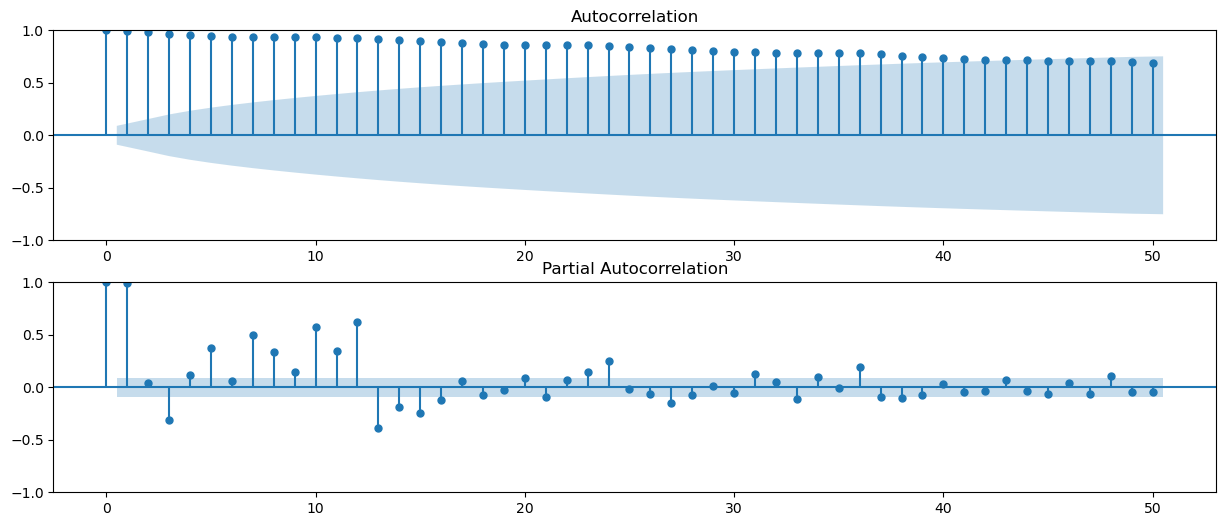

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

nlags = 50 # play with this parameter

# ValueError: Can only compute partial correlations for lags up to 50% of the sample size.

fig, ax = plt.subplots(2,1, figsize = (15,6))

plot_acf(y, lags = nlags, ax=ax[0])
plot_pacf(y, lags = nlags, method="ols", ax=ax[1])
plt.show()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           22     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31000D+00    |proj g|=  7.23368D+00

At iterate    5    f= -2.36582D+00    |proj g|=  1.03798D-01

At iterate   10    f= -2.38149D+00    |proj g|=  2.31382D+00

At iterate   15    f= -2.39162D+00    |proj g|=  3.42167D-01

At iterate   20    f= -2.39323D+00    |proj g|=  2.80401D-01

At iterate   25    f= -2.39567D+00    |proj g|=  1.63054D-01

At iterate   30    f= -2.39676D+00    |proj g|=  1.21768D-02

At iterate   35    f= -2.39708D+00    |proj g|=  1.35914D-01

At iterate   40    f= -2.39724D+00    |proj g|=  3.53611D-02

At iterate   45    f= -2.39813D+00    |proj g|=  1.99525D-01

At iterate   50    f= -2.39881D+00    |proj g|=  2.16555D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

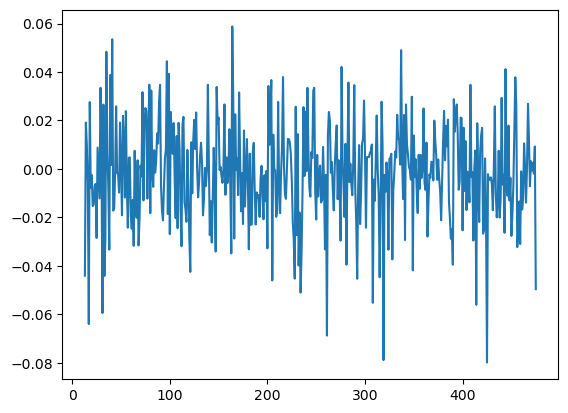

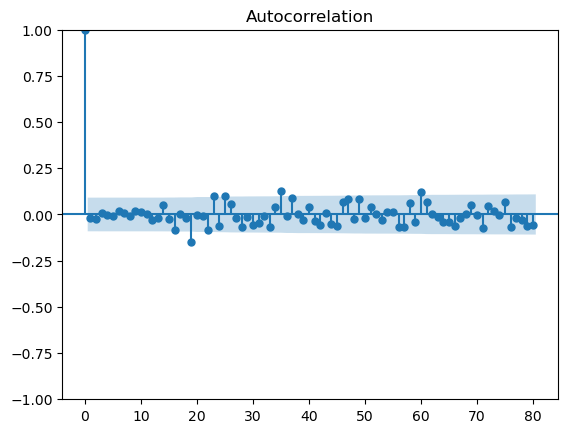

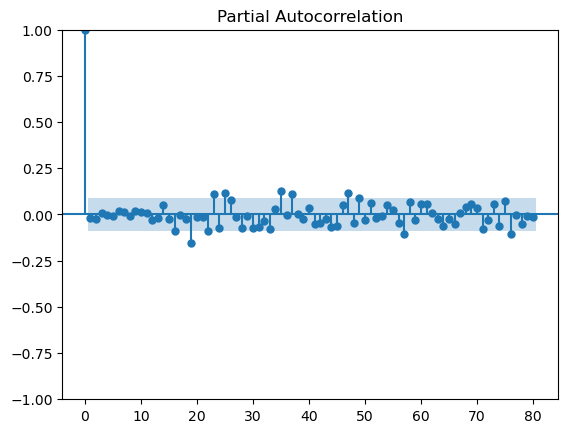

In [16]:
s = 12 # seasonal period

fit = SARIMAX(endog = y, order = (7,1,11), seasonal_order = (1,1,2,s)).fit()
# AR is for the PACF, MA is for the ACF
print(fit.summary())
residuos = fit.resid[13:]

nlags=80

plt.plot(residuos)
plt.show()
plot_acf(residuos, lags = nlags)
plt.show()
plot_pacf(residuos, method="ols",lags = nlags)
#plot_pacf(residuos,lags = nlags)
plt.show()

In [5]:
d = ndiffs(residuos, alpha = 0.05, test='adf')  # regular differences?
D = nsdiffs(residuos, m = s, test='ocsb') # # seasonal differences?

print("Regular differences: ", d)
print('Seasonal differences:', D)

Regular differences:  0
Seasonal differences: 0


Ljung-Box for the residuals
     lb_stat  lb_pvalue
25  32.68989   0.139005
Shapiro test for residuals: Statistic value 0.9893631935119629 p-value 0.0019377353601157665


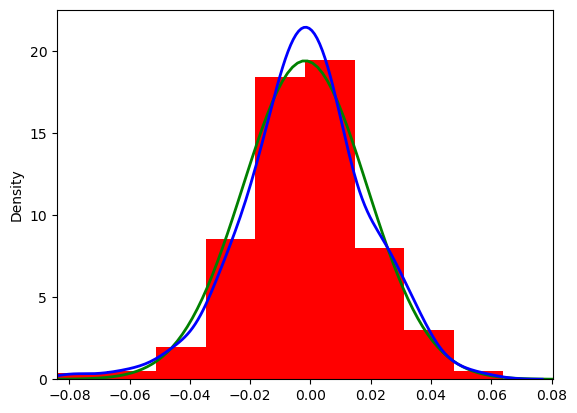

In [17]:
# Box test for autocorrelations

import statsmodels.api as sm
box_test = sm.stats.acorr_ljungbox(residuos, lags=[25])

print("Ljung-Box for the residuals")
print(box_test)

from scipy.stats import shapiro
import seaborn as sns
import scipy.stats as st

# Normalitresiduos test

saphiro = shapiro(residuos)
print("Shapiro test for residuals: Statistic value", saphiro[0],"p-value",saphiro[1]) # first output "The test statistic", second output "p-value"

mean = np.mean(residuos)
std = np.std(residuos)
mu = np.mean(residuos)
sigma = np.std(residuos)
x = np.linspace(mu -4*sigma, mu +4*sigma, 100)
pdf = st.norm.pdf(x, mu, sigma)
ax = plt.plot(x, pdf, lw = 2, color = "g")
ax = plt.hist(residuos,density=True, range = (mean - 4*std, mean + 4*std), color = "r")
ax = sns.distplot(residuos, hist = False, kde = True,
                 kde_kws = {'linewidth': 2}, color = "blue")
ax.set_xlim(mean - 4*std, mean + 4*std)

plt.show()

# To have white noise, the p-value of the Ljung-Box test has to be greater than 0.05 (uncorrelated residuals)
# to have normality, the p-value of the Shapiro test has to be greater than 0.05

Ljung-Box for squared residuals
      lb_stat  lb_pvalue
20  19.420186   0.494683


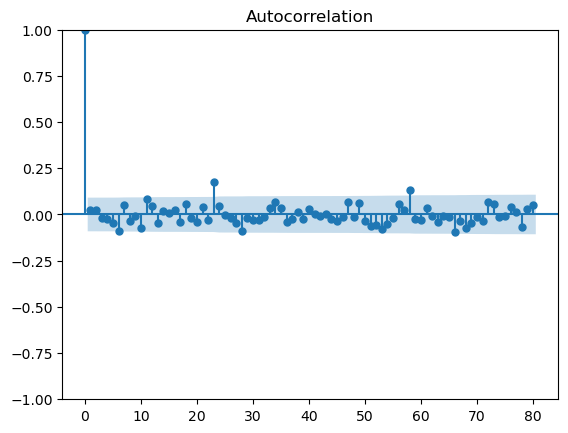

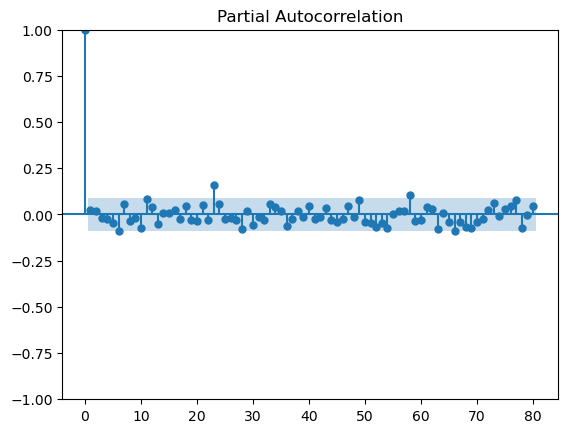

In [7]:
# Study the squared residuals for SWN

box_test2 = sm.stats.acorr_ljungbox(residuos**2, lags=[20])
print("Ljung-Box for squared residuals")
print(box_test2)

plot_acf(residuos**2,lags=nlags)
plt.show()
plot_pacf(residuos**2,lags=nlags,method="ols")
plt.show()

# if the p-value of the Ljung-Box test is greater than 0.05, the residuals are uncorrelated and we need a model for the variance.

In [8]:
'''# Pintamos las siguientes 24 predicciones
y_pred = fit.forecast(steps = 12)

# Ponemos el último índice real
y_pred.loc[len(y)-1] = y[len(y)-1]

# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.
y_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')

# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo
# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio
# print(y_pred)
plt.figure(figsize = (13,5))
plt.plot(y, label = 'Real')
plt.plot(y_pred, label = 'Pred')
plt.legend()
plt.show()'''

"# Pintamos las siguientes 24 predicciones\ny_pred = fit.forecast(steps = 12)\n\n# Ponemos el último índice real\ny_pred.loc[len(y)-1] = y[len(y)-1]\n\n# Reseteamos los índices, ordenamos por índice y volvemos a poner el índice como índice de la Serie.\ny_pred = y_pred.reset_index().sort_values(by = 'index').set_index('index')\n\n# Las predicciones dan 0, el modelo arriba que está con todos los parámetros en 0 salvo\n# el 's' no sé si dará algún problema en Python y no lo haga como en R o me he equivocado en otro sitio\n# print(y_pred)\nplt.figure(figsize = (13,5))\nplt.plot(y, label = 'Real')\nplt.plot(y_pred, label = 'Pred')\nplt.legend()\nplt.show()"

In [9]:
# MORE FORECAST INFORMATION

forecast_result = fit.get_forecast(steps=12)
y_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)  
stderr = forecast_result.se_mean 

print("point predictions")
print(y_pred)
print("confidence intervals around point predictions")
print(conf_int)
print("standard error of point predictions")
print(stderr)

point predictions
476    9.545095
477    9.517546
478    9.501691
479    9.511410
480    9.514867
481    9.475159
482    9.529873
483    9.494911
484    9.573965
485    9.562405
486    9.619842
487    9.568309
Name: predicted_mean, dtype: float64
confidence intervals around point predictions
     lower TOTAL  upper TOTAL
476     9.494670     9.595521
477     9.461194     9.573899
478     9.439445     9.563937
479     9.443642     9.579177
480     9.442366     9.587367
481     9.399549     9.550769
482     9.453070     9.606676
483     9.416932     9.572889
484     9.494829     9.653101
485     9.482128     9.642683
486     9.538439     9.701244
487     9.485797     9.650822
standard error of point predictions
476    0.025728
477    0.028752
478    0.031759
479    0.034576
480    0.036991
481    0.038577
482    0.039186
483    0.039786
484    0.040376
485    0.040959
486    0.041533
487    0.042099
Name: var_pred_mean, dtype: float64


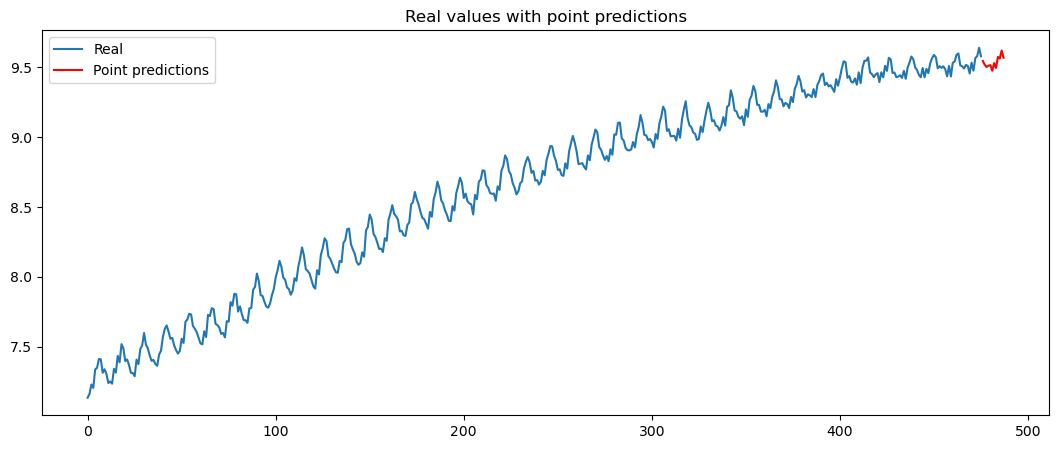

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

'''
Asumiendo que 'pred_means' contiene tus predicciones como una serie de pandas
y que 'y' es tu serie temporal original
'''

# Crear un nuevo índice para las predicciones que continúe desde el último índice de 'y'
nuevos_indices = range(y.index[-1] + 1, y.index[-1] + 1 + len(y_pred))

# Crear una nueva serie de pandas para las predicciones, usando los nuevos índices
y_predicciones = pd.Series(y_pred, index=nuevos_indices)

# Trazar
plt.figure(figsize=(13, 5))
plt.plot(y, label='Real')
plt.plot(y_predicciones, 'r', label='Point predictions')
plt.legend()
plt.title('Real values with point predictions')
plt.show()

In [11]:
# MORE FORECAST INFORMATION

media = np.mean(residuos)
desviacion_std = np.std(residuos)

# Standardized residuals
residuos_estand = (residuos - media) / desviacion_std

# Verification
#print("Standardized residuals:", residuos_estand)
print("Mean:", np.mean(residuos_estand))
print("Standard deviation:", np.std(residuos_estand))


quantile_2_5=np.quantile(residuos_estand, 0.025)
quantile_97_5=np.quantile(residuos_estand, 0.975)

print("We must compare the following numbers with +/- 1.96 from the standard normal")
print(quantile_2_5,quantile_97_5)

Mean: 1.9183119215985427e-18
Standard deviation: 0.9999999999999997
We must compare the following numbers with +/- 1.96 from the standard normal
-2.01972606803286 1.9142090429309393
